In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(palette='colorblind')
import os.path

import refnx, scipy

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import ReflectModel, MDSimulation

# the analysis module contains the curvefitting engine
from refnx.analysis import Objective, Transform, CurveFitter

import sys
sys.path.insert(0, '../../bin')
sys.path.insert(0, '../../models')
import sim_lengths as sl

mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.facecolor'] = [1,1,1]
mpl.rcParams['legend.framealpha'] = 0.75
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['axes.edgecolor'] = 'k'

In [2]:
# version numbers used in this analysis
refnx.version.version, scipy.version.version

('0.1.1.dev0+86435b1', '1.1.0')

In [3]:
forcefield = 'martini'
surface_pressure = '30'
label = 'd13d2o'
traj_dir = '../../data/simulation/{}/surf_pres_{}/'.format(forcefield, surface_pressure)

head = ['D']
tail = ['H']
sol = ['D']
labels = ['d13d2o']

for k in range(0, len(labels)):
    if labels[k] == label:
        break
models = []
datasets = []
structures = []

lgts = sl.get_lgts(head[k], tail[k], sol[k], forcefield)
l = np.array([])
timesteps = 0
for i in range(1, 11):
    print('frame{}'.format(i))
    try:
        del sim
    except:
        pass
    if forcefield == 'martini':
        lt = 1
        rough = 0
        co = 30
    else:
        lt = 1
        rough = 0.
        co = 15
    sim = MDSimulation(os.path.join(traj_dir, 'frame{}.pdb'.format(i)), flip=True, 
                       verbose=True, layer_thickness=lt, roughness=rough)

    sim.assign_scattering_lengths('neutron', atom_types=lgts[0], scattering_lengths=lgts[1])

    sim.run()
    layers_to_cut = int(co / lt) + 1
    timesteps += sim.layers.shape[0]
    l = np.append(l, sim.layers[:, :-layers_to_cut, :])

n = l.reshape(timesteps, sim.layers.shape[1]-layers_to_cut, sim.layers.shape[2])
data_dir = '../../data/experimental/surf_pres_{}/'.format(surface_pressure)
dataset = ReflectDataset(os.path.join(data_dir, '{}{}.dat'.format(label, surface_pressure)))


refy = np.zeros((n.shape[0], dataset.x.size))
sldy = []
chi = np.zeros((n.shape[0]))

for i in range(n.shape[0]):
    sim.av_layers = n[i, :, :]
    model = ReflectModel(sim)
    model.scale.setp(100, vary=True, bounds=(0.00000001, np.inf))
    model.bkg.setp(dataset.y[-1], vary=False)
    objective = Objective(model, dataset, transform=Transform('YX4'))
    fitter = CurveFitter(objective)
    res = fitter.fit()
    refy[i] = model(dataset.x, x_err=dataset.x_err)*(dataset.x)**4
    sldy.append(sim.sld_profile()[1])
    chi[i] = objective.chisqr()
    
import scipy
from scipy.stats.mstats import mquantiles
chi_arr = mquantiles(chi, prob=[0.025, 0.5, 0.975])
chia = '{:.1f}'.format(chi_arr[1])

chi_out = open('../../output/simulation/{}_{}_{}_chisq_order.txt'.format(label, forcefield, surface_pressure), 'w')
chi_out.write('$' + str(chia) + '$')
chi_out.close()

ref_out = open('../../output/simulation/{}_{}_{}_ref_order.txt'.format(label, forcefield, surface_pressure), 'w')
for i in range(dataset.x.size):
    ref_out.write('{} {} {} '.format(dataset.x[i], dataset.y[i]*(dataset.x[i])**4, dataset.y_err[i]*(dataset.x[i])**4))
    for j in range(n.shape[0]):
        ref_out.write('{} '.format(refy[j, i]))
    ref_out.write('\n')
ref_out.close()

sld_out = open('../../output/simulation/{}_{}_{}_sld_order.txt'.format(label, forcefield, surface_pressure), 'w')
sldya = np.asarray(sldy)
for i in range(sim.sld_profile()[0].shape[0]):
    sld_out.write('{} '.format(sim.sld_profile()[0][i]))
    for j in range(sldya.shape[0]):
        sld_out.write('{} '.format(sldya[j, i]))
    sld_out.write('\n')
sld_out.close()

frame1


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame2


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame3


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame4


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame5


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame6


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame7


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame8


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame9


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.
frame10


/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'N' for Atom (name=NC3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Used element 'P' for Atom (name=PO4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstructionWarning: Could not assign element 'G' for Atom (name=GL2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/andrew/miniconda3/envs/sim_vs_trad/lib/python3.6/site-packages/Bio/PDB/Atom.py:185: PDBConstr

PDB file read.
Scattering lengths found.
SLD profile determined.


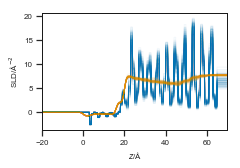

In [14]:
plt.subplots(figsize=(3.5, 2.5))
colors = ["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC", "#CA9161", "#FBAFE4"]
files = ['../../output/simulation/d13d2o_martini_30_sld_order.txt', '../../output/simulation/d13d2o_martini_30_sld.txt']
for k, b in enumerate(files):
    data = np.loadtxt(b, unpack=True)
    to_plot = np.random.randint(1, data.shape[0], size=100)
    for j in to_plot:
        x2 = np.linspace(-20, data[0].min(), 100)
        x = np.append(x2, data[0])
        y2 = np.zeros_like(x2)
        y = np.append(y2, data[j])
        if x.max() < 70:
            x3 = np.linspace(x.max(), 71, 100)
            y3 = np.ones_like(x3) * y[-1]
            x = np.append(x, x3)
            y = np.append(y, y3)
        x = x[np.where(x < 70)]
        y = y[np.where(x < 70)]
        plt.plot(x, y*10, c=colors[k], lw=1, ls='-', alpha=0.05)
plt.ylabel(r'SLD/Å$^{-2}$')
plt.xlabel(r'$z$/Å')
plt.xlim([-20, 70])
plt.tight_layout()
plt.savefig('../../reports/figures/martiniorder.pdf')